In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    BequestWarmGlowConsumerType,
    init_warm_glow,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_warm_glow)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": [1.0] * len(liv_prb)})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
TerminalExample = BequestWarmGlowConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
TerminalExample.cycles = 1

In [4]:
start_time = time()
TerminalExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
TerminalExample.unpack("cFunc")

Solving a lifecycle consumer took 0.23761677742004395 seconds.


Consumption functions


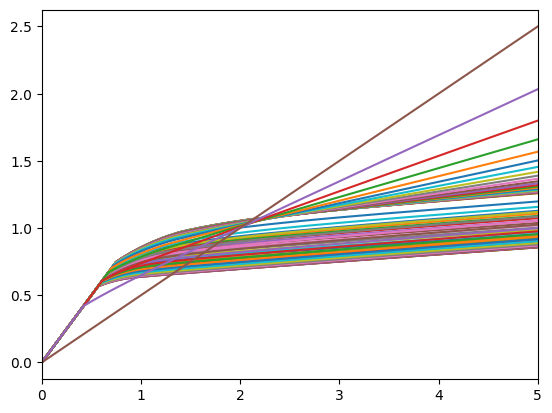

In [5]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(TerminalExample.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
TerminalExample.AgentCount = 500
TerminalExample.T_sim = 200

# Set up the variables we want to keep track of.
TerminalExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
TerminalExample.initialize_sim()
TerminalExample.simulate()

{'aNrm': array([[0.32426629, 0.70206002, 0.34318066, ..., 1.48985662, 3.45438995,
         0.22773623],
        [0.12491832, 0.55855075, 1.19638637, ..., 1.21659401, 3.11015491,
         1.12183257],
        [0.0994806 , 0.8181565 , 1.21644532, ..., 0.52555426, 2.15858826,
         0.99831787],
        ...,
        [1.3049415 , 0.42555252, 1.09378696, ..., 0.23810415, 2.77931762,
         0.17060085],
        [1.01614121, 0.10904969, 0.23944278, ..., 0.54243046, 3.24416828,
         0.50733475],
        [1.05863018, 0.56999085, 0.40866293, ..., 0.17076358, 3.31047178,
         0.79032783]]),
 'cNrm': array([[0.84037767, 0.90481749, 0.84523877, ..., 0.97357366, 1.10298102,
         0.80945367],
        [0.75444197, 0.87244871, 0.93396861, ..., 0.93550845, 1.05993699,
         0.92824936],
        [0.73609404, 0.89128728, 0.92297277, ..., 0.85895892, 0.9851216 ,
         0.90655719],
        ...,
        [0.92924216, 0.8433773 , 0.91393767, ..., 0.79750399, 1.02342963,
         0.7714992

In [7]:
raw_data = {
    "Age": TerminalExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": TerminalExample.history["pLvl"].flatten(),
    "nrmM": TerminalExample.history["mNrm"].flatten(),
    "nrmC": TerminalExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

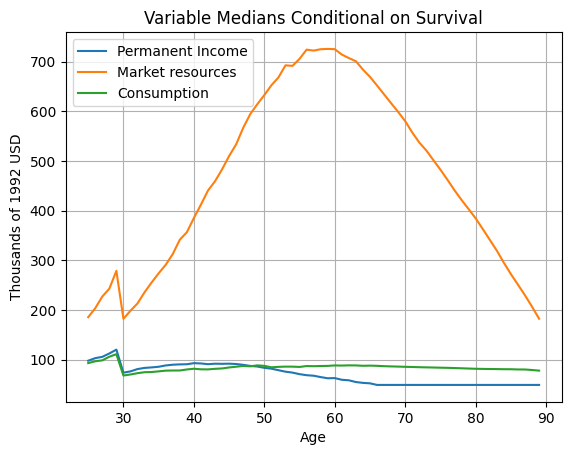

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()